# TestCase4 v2 - Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 4
version = 7
assert version in [2, 3, 4, 5, 7]
param_num = 1

**Idée :** On se place ici dans le TestCase3.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modules.utils import create_tree

from modules.geometry import Donut
from modules.fenics_expressions import FExpr,UexExpr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [4]:
if testcase == 4:
    if version == 2:
        from modules.testcases.d2.test_4.test_4_v2 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut import FEMSolver
    elif version == 3:
        from modules.testcases.d2.test_4.test_4_v3 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut import FEMSolver
    elif version == 4:
        from modules.testcases.d2.test_4.test_4_v4 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut_v4_new import FEMSolver
    elif version == 7:
        from modules.testcases.d2.test_4.test_4_v7 import Run_laplacian2D,Poisson_2D
        from modules.solver_fem_4_donut_v4_new import FEMSolver
    else:
        raise ValueError("Version not found")
    from modules.problem import TestCase4
    problem = TestCase4(v=version)
else:
    raise ValueError("Testcase not found")

result_dir = "../../../results/2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

torch loaded; device is cuda


>> load network /home/flecourtier/Bureau/Article1/code/networks/test_fe4_v7.pth
jsbdbshd
network loaded


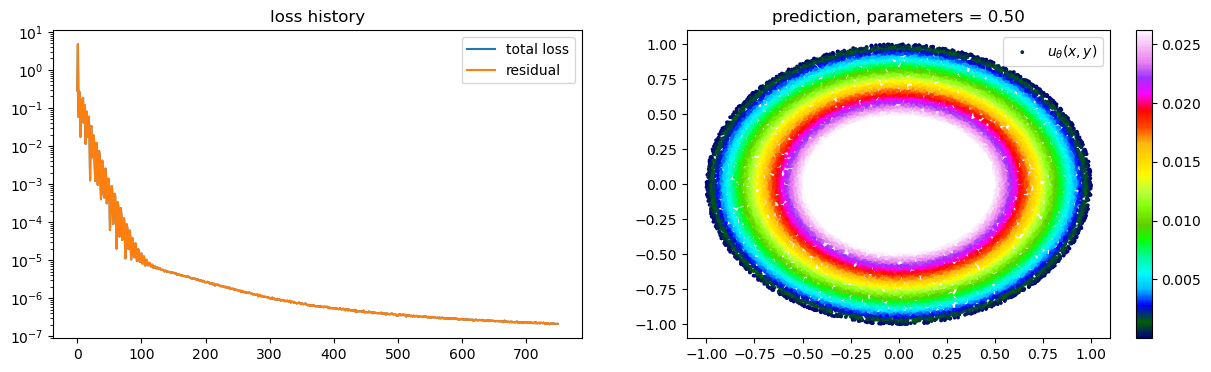

In [5]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [6]:
def get_param(i):
    parameter_domain = problem.parameter_domain
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = []
        for k in range(len(parameter_domain)):
            param.append(np.random.uniform(parameter_domain[k][0], parameter_domain[k][1]))
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.5]


In [7]:
from modules.fenics_expressions import MyUserExpression

class UthetaExpr(MyUserExpression):
    def __init__(self, params, degree, domain, pb_considered):
        super().__init__(degree, domain)
        self.mu = params
        self.pb_considered = pb_considered
    
    def eval(self, value, x):
        x = np.array([x])
        
        X_test = torch.tensor(x,requires_grad=True)
        X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

        # get parameters
        shape = (x.shape[0],1)
        ones = torch.ones(shape)
        mu_test = (torch.Tensor(params[0]).to(device) * ones).to(device)
            
        pred = u_theta.setup_w_dict(X_test, mu_test)
        value[0] = pred["w"][:,0].cpu().detach().numpy()

## Solution de référence

In [8]:
from dolfin import *
prm = parameters["krylov_solver"]
prm["absolute_tolerance"] = 1e-13
prm["relative_tolerance"] = 1e-13

In [9]:
import mshr

def create_ref_domain(deg,nb_vert=500,H=None):    
    # check if pb_considered is instance of Square class
    if isinstance(problem.geometry, Donut):
        bigcenter = problem.geometry.bigcircle.center
        bigradius = problem.geometry.bigcircle.radius
        smallcenter = problem.geometry.hole.center
        smallradius = problem.geometry.hole.radius
        box = np.array(problem.geometry.box)

        bigcircle = mshr.Circle(df.Point(bigcenter[0],bigcenter[1]), bigradius)
        hole = mshr.Circle(df.Point(smallcenter[0],smallcenter[1]), smallradius)
        domain = bigcircle-hole    
    
        mesh_macro = RectangleMesh(Point(box[0,0], box[1,0]), Point(box[0,1], box[1,1]), nb_vert, nb_vert)
        h_macro = mesh_macro.hmax()
        print("h_macro = ",h_macro)
        
        if H is None:
            # H = int(nb_vert*3/5)
            H=700
        else:
            H = int(H)
        mesh_ref = mshr.generate_mesh(domain,H)
        h = mesh_ref.hmax()
        while h > h_macro:
            H += 1
            mesh_ref = mshr.generate_mesh(domain,H)            
            h = mesh_ref.hmax()
            print("h : ",h)
    else:
        raise ValueError("Geometry not implemented")
    
    V_ref = df.FunctionSpace(mesh_ref, "CG", deg)
    print(V_ref.tabulate_dof_coordinates().shape)
    dx_ref = df.Measure("dx", domain=mesh_ref)
    
    h_ref = mesh_ref.hmax()
    print("hmax = ",h_ref)

    return mesh_ref, V_ref, dx_ref, H
    
def get_uref(param,deg,nb_vert=500,H=None):
    mesh_ref, V_ref, dx_ref, H = create_ref_domain(deg,nb_vert,H)
    
    f_expr = FExpr(param, degree=10, domain=mesh_ref, pb_considered=problem)  
      
    g = Constant("0.0")
    
    if version == 2 or version == 3:
        def boundary_D(x,on_boundary):
            return on_boundary and x[0]**2+x[1]**2<0.75**2
        
        bc = DirichletBC(V_ref, g, boundary_D)
    elif version==4:
        bc = DirichletBC(V_ref, g, "on_boundary")
    
    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)
    
    # Resolution of the variationnal problem

    a = df.inner(df.grad(u),df.grad(v)) * dx_ref
    l = f_expr * v * dx_ref

    sol = df.Function(V_ref)
    df.solve(a==l, sol, bcs=bc, solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

    return sol,H


In [10]:
if testcase != 4 and testcase != 7:
    savedir = result_dir + "u_ref/"
    create_tree(savedir)

    nb_vert = 500
    deg_uref = 3

    filename = f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H*.npy"
    pattern = os.path.join(savedir, filename)

    import glob
    matching_files = glob.glob(pattern)

    load_ref = True
    if not load_ref or not matching_files:
        print("Run")
        if matching_files:
            H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
            u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert,H=H)
        else:
            u_ref,H = get_uref(param,deg=3,nb_vert=nb_vert)
        vct_u_ref = u_ref.vector().get_local()
        filename = savedir + f"u_ref_{param_num}_P{deg_uref}_N{nb_vert}_H{H}.npy"
        np.save(filename, vct_u_ref)  
    else:
        print("Load")
        vct_u_ref = np.load(matching_files[0])
        H = int(matching_files[0].split("_")[-1].split(".")[0][1:])
        mesh_ref, V_ref, dx_ref, _ = create_ref_domain(deg=deg_uref,nb_vert=nb_vert,H=H)
        u_ref = df.Function(V_ref)
        u_ref.vector()[:] = vct_u_ref

In [11]:
if testcase != 4 and testcase != 7:
    plt.figure()
    plot(mesh_ref)
    plt.show()

In [12]:
if testcase != 4 and testcase != 7:
    plt.figure()
    c = plot(u_ref)
    plt.colorbar(c)
    plt.show()

## Convergence FEM

In [13]:
def read_csv(testcase,param_num,degree):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    df_FEM = pd.read_csv(csv_file)  
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        print("Run FEM")
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            tab_h_FEM.append(solver.h)
            if version == 4 or version == 7:
                _,norme_L2 = solver.fem(0)
            else:
                _,norme_L2 = solver.fem(0,u_ref)
                
            
            # colormap = "jet"
            # plt.figure()
            # c = df.plot(sol,cmap=colormap)
            # plt.colorbar(c)
            # plt.show()
            
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [14]:
degree = 2
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)

Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param1_degree2.csv


degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param1_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param1_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param1_degree3.csv


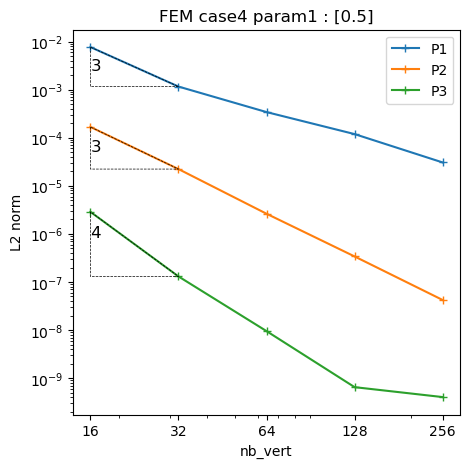

In [15]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_FEM[1],tab_err_FEM[1]]
    end = [tab_nb_vert_FEM[0],tab_err_FEM[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['nb_vert'], df_FEM['nb_vert'].round(3).astype(str))
plt.xlabel('nb_vert')
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [16]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_FEM, _, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['N'] = tab_nb_vert_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param1_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param1_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param1_degree3.csv


## Convergence PINNs+Corr

In [17]:
# def get_test_sample(i,solver,trainer,deg_PINNs):
#     # get coordinates of the dof
#     V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
#     XXYY = V_test.tabulate_dof_coordinates()
#     X_test = torch.tensor(XXYY,requires_grad=True)
#     X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

#     # get parameters
#     nb_params = len(trainer.pde.parameter_domain)
#     shape = (XXYY.shape[0],nb_params)
#     ones = torch.ones(shape)
#     mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

#     return V_test,X_test,mu_test

In [20]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False,plot_all = False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        # tab_nb_vert_Corr = [2**i for i in range(4,9)]
        tab_nb_vert_Corr = [16,32,64]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
            
            # plt.figure()
            # df.plot(solver.mesh)
            # plt.show()
            
            tab_h_Corr.append(solver.h)
            
            # V_test,X_test,mu_test = get_test_sample(0,solver,trainer,degree_PINNs)
            # pred = u_theta.setup_w_dict(X_test, mu_test)
            # phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            # u_PINNs = df.Function(V_test)
            # u_PINNs.vector()[:] = phi_tild.copy()
            
            if version == 4 or version == 7:
                u_ref = UexExpr(param, degree=10, domain=solver.mesh, pb_considered=problem)
                u_PINNs = UthetaExpr(param, degree=10, domain=solver.mesh, pb_considered=problem)
            uref_Vex = interpolate(u_ref,solver.V_ex)
            sol_Vex = interpolate(u_PINNs,solver.V_ex)
            norme_L2_PINNs = (assemble((((uref_Vex - sol_Vex)) ** 2) * solver.dx) ** (0.5)) / (assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))

            print(f"nb_vert={nb_vert}, norme_L2_PINNs={norme_L2_PINNs}")
            
            if version==2: # on a une loss BC pr Dirichlet
                nonexactBC = True
            elif version==3 or version==4 or version==7: # on utilise la levelset
                nonexactBC = False
            elif version==5: # on a pas de Dirichlet
                nonexactBC = None
            else:
                raise ValueError("Version not found")
            
            if testcase == 4:
                sol,C_tild,norme_L2 = solver.corr_add(0,u_PINNs,nonexactBC=nonexactBC)
            else:
                sol,C_tild,norme_L2 = solver.corr_add(0,u_PINNs,u_ref,nonexactBC=nonexactBC)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
            #### PLOTT
            if plot_all and nb_vert in [16,32,64]:
                colormap = "jet"
                
                # V_test_,X_test_,mu_test_ = get_test_sample(0,solver,trainer,degree)
                # pred = u_theta.setup_w_dict(X_test_, mu_test_)
                # phi_tild = pred["w"][:,0].cpu().detach().numpy()

                # u_PINNs_1 = df.Function(solver.V)
                # u_PINNs_1.vector()[:] = phi_tild.copy()

                u_PINNs_1 = interpolate(u_PINNs,solver.V)


                C_ex = df.Function(solver.V)
                u_ref_inter = df.interpolate(u_ref,solver.V)
                C_ex.vector()[:] = u_ref_inter.vector()[:] - u_PINNs_1.vector()[:]

                plt.figure(figsize=(15,10))

                plt.subplot(2,3,1)
                c = df.plot(C_ex,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_ex")

                plt.subplot(2,3,2)
                c = df.plot(C_tild,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_tild")

                plt.subplot(2,3,3)
                error = df.Function(solver.V)
                error.vector()[:] = C_ex.vector()[:] - C_tild.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title("C_ex-C_tild")
                
                plt.subplot(2,3,4)
                c = df.plot(u_ref_inter,cmap=colormap)
                plt.colorbar(c)
                plt.title("u_ex")
                
                plt.subplot(2,3,5)
                # sol_inter = df.project(sol,solver.V)
                sol_inter = df.Function(solver.V)
                sol_inter.vector()[:] = u_PINNs_1.vector()[:] + C_tild.vector()[:]
                c = df.plot(sol_inter,cmap=colormap)
                plt.colorbar(c)
                plt.title("sol")
                
                plt.subplot(2,3,6)
                error = df.Function(solver.V)
                error.vector()[:] = u_ref_inter.vector()[:] - sol_inter.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title(f"u_ex-sol\nL2 norm : {norme_L2:.2e}")    
                
                plt.suptitle(f"nb_vert={nb_vert}")
                
                plt.savefig(result_dir+f'plotcorr_case{testcase}_v{version}_N{nb_vert}_degree{degree}.png')

        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

hmax =  0.16663035129479017


/tmp/ipykernel_328149/3258187753.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  value[0] = pred["w"][:,0].cpu().detach().numpy()


nb_vert=16, norme_L2_PINNs=0.0005000667640466807
nb_vert=16, norme_L2=3.3463300484386472e-06
hmax =  0.08691933730437637
nb_vert=32, norme_L2_PINNs=0.0005039581984388886
nb_vert=32, norme_L2=4.2989709828566e-07
hmax =  0.04347038548979546
nb_vert=64, norme_L2_PINNs=0.0005050977339221281
nb_vert=64, norme_L2=5.620939736376512e-08


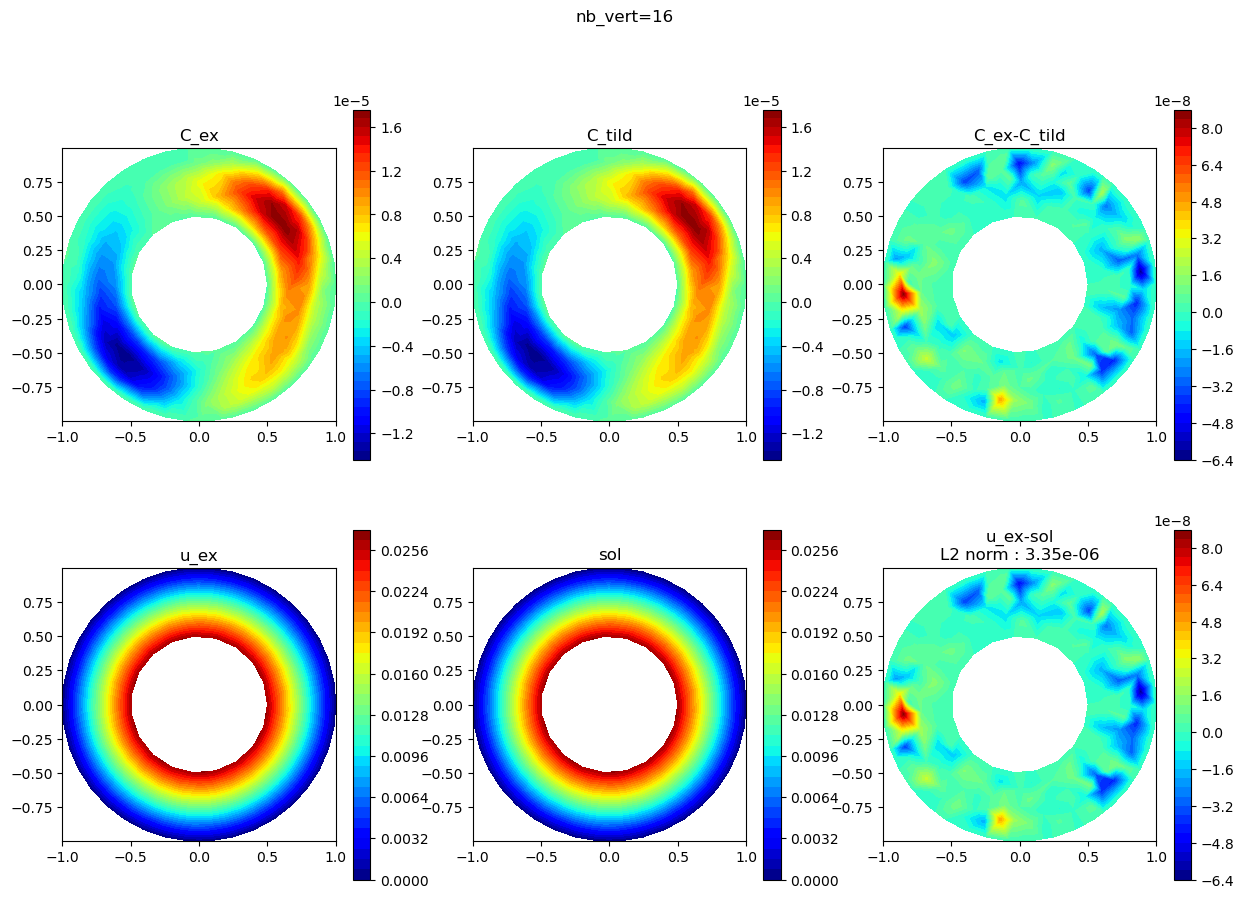

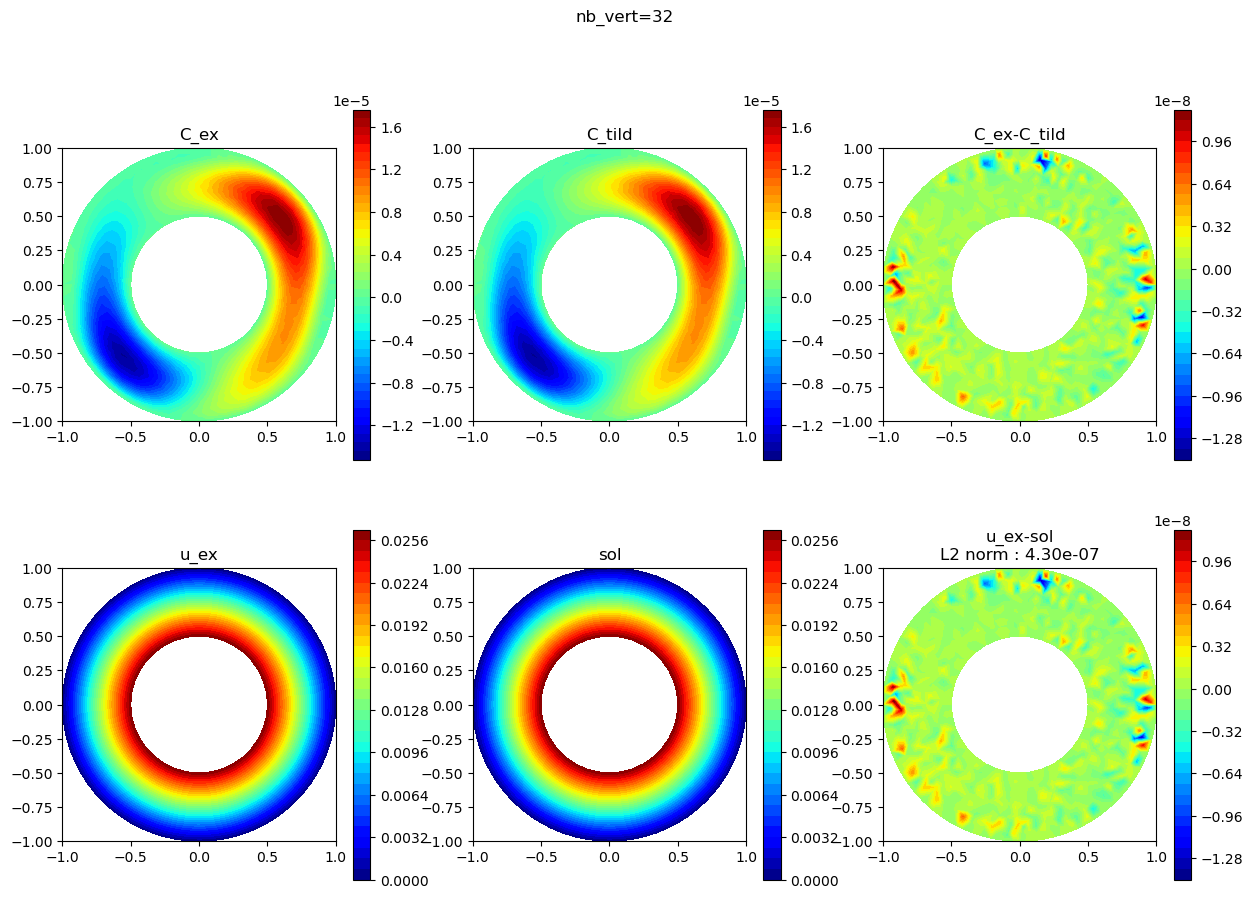

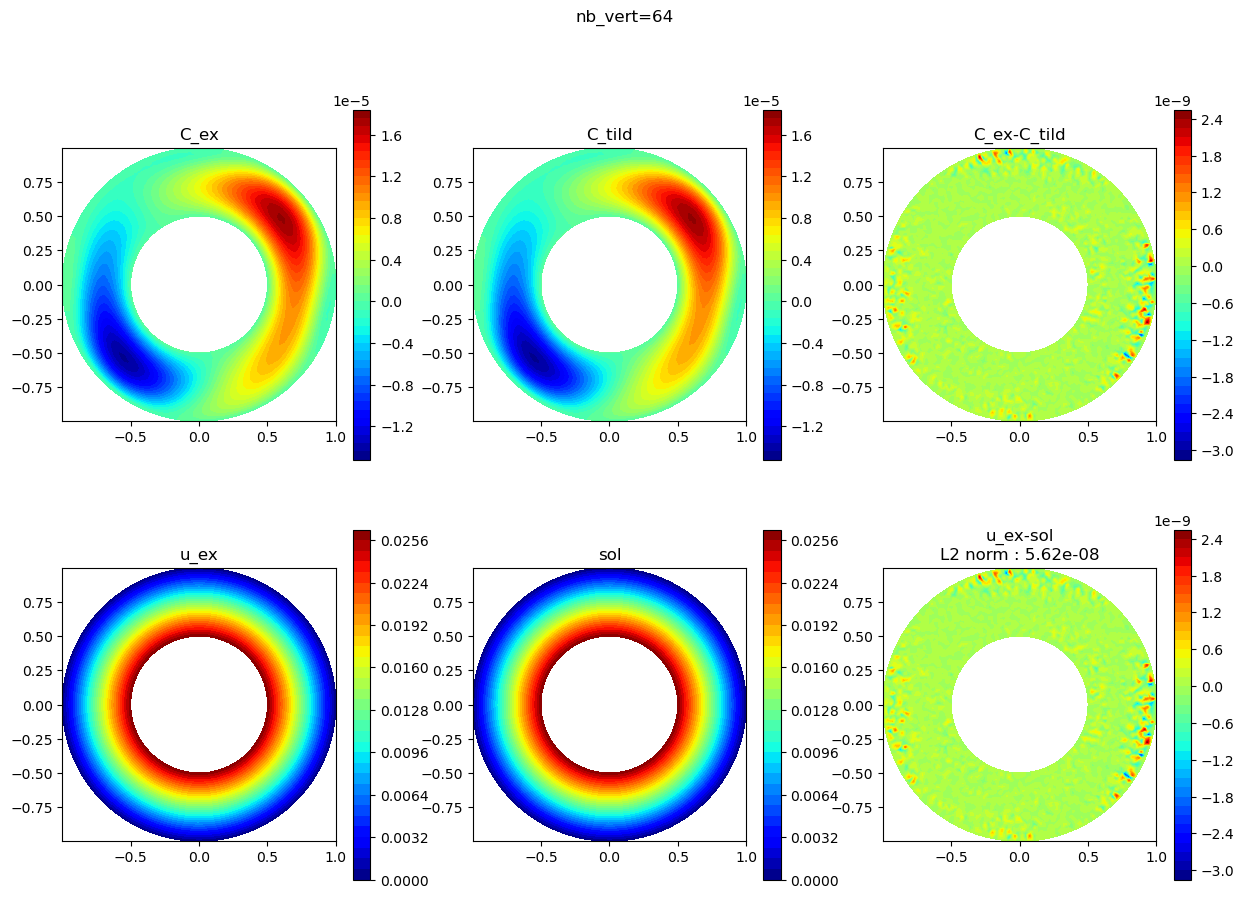

In [21]:
degree = 2
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(degree,new_run=True,plot_all=True)

degree=1
hmax =  0.16663035129479017
nb_vert=16, norme_L2_PINNs=0.0005000667640466932
nb_vert=16, norme_L2=3.77546191401314e-05
hmax =  0.08691933730437637
nb_vert=32, norme_L2_PINNs=0.0005039581984388835
nb_vert=32, norme_L2=1.1926760360391783e-05
hmax =  0.04347038548979546
nb_vert=64, norme_L2_PINNs=0.0005050977339221351
nb_vert=64, norme_L2=3.4743139370329225e-06
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param1_degree2.csv
degree=3
hmax =  0.16663035129479017
nb_vert=16, norme_L2_PINNs=0.0005000667640466932
nb_vert=16, norme_L2=3.14966122432864e-07
hmax =  0.08691933730437637
nb_vert=32, norme_L2_PINNs=0.0005039581984388835
nb_vert=32, norme_L2=1.9472825220126203e-08
hmax =  0.04347038548979546
nb_vert=64, norme_L2_PINNs=0.0005050977339221351
nb_vert=64, norme_L2=1.269379571969918e-09


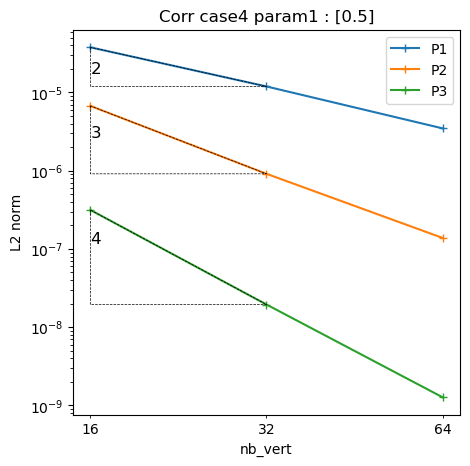

In [22]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))
    
    # add slope with a triangle
    start = [tab_nb_vert_Corr[1],tab_err_Corr[1]]
    end = [tab_nb_vert_Corr[0],tab_err_Corr[0]]
    third = [end[0],start[1]]
    
    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)
    
    slope = (np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = abs(int(slope.round(0)))

    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [23]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param1_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param1_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param1_degree3.csv


## Plots

degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param1_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/FEM_case4_param1_degree2.csv
degree=3
Run FEM
hmax =  0.16663035129479017
nb_vert=16, norme_L2=2.878926039074868e-06
hmax =  0.08691933730437637
nb_vert=32, norme_L2=1.3048906158891938e-07
hmax =  0.04347038548979546
nb_vert=64, norme_L2=9.51396257370948e-09
hmax =  0.02197797091453632
nb_vert=128, norme_L2=6.503453774623039e-10
hmax =  0.010988924822874708
nb_vert=256, norme_L2=4.043432896093516e-10
degree=1
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param1_degree1.csv
degree=2
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param1_degree2.csv
degree=3
Read csv file ../../../results/2D/testcase4/version7/cvg/Corr_case4_param1_degree3.csv


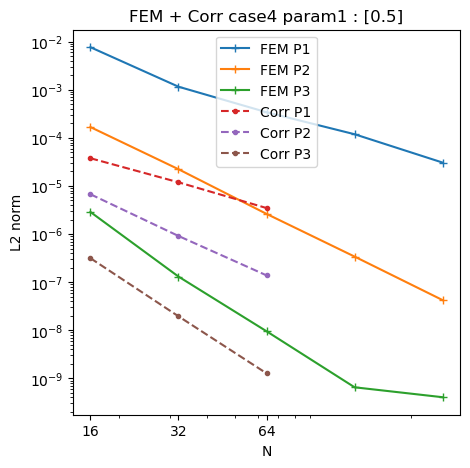

In [24]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')